In [1]:
# import libraries
import geopandas as gpd
import ipywidgets as widgets
from IPython.display import display
#from IPython.display import Javascript

import os
import zipfile
import requests
import time

from geopy.geocoders import Nominatim
geolocator = Nominatim()

import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

# custom modules
import map_html
import cal_zoom
from cal_zoom import get_zoom_start

import warnings
warnings.filterwarnings('ignore')

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  del sys.path[0]


In [2]:
# load Natural Earth datasetand from continent select South America and country names
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = world.loc[world['continent'] == 'South America', 'name'].sort_values()

# uncomment this line if you want to select a country outside South America
#countries =world['name'].sort_values()

In [3]:
# set up a Jupyter Notebbok dropdown widget to pick up a county of interest
w = widgets.Dropdown(
    options= countries,
    value='Venezuela'
)

display(w)

# Javascript('IPython.notebook.execute_cells_below()')

# def run_all(ev):
#     display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,\
#     IPython.notebook.ncells())'))

# button = widgets.Button(description="Run All Cells ")
# button.on_click(run_all)

# display(button)

Dropdown(index=12, options=('Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Falkland Is.', …

In [4]:
# visualize selected county name
w.value

'Venezuela'

In [5]:
# source: https://blog.goodaudience.com/geo-libraries-in-python-plotting-current-fires-bffef9fe3fb7
# create a function to set up folder names according the current date and time
def make_folder_name(localtime):
    '''
    this function will help us to set up folder names according to our current local date and time
    '''
    if localtime.tm_hour > 12:
        string = str(localtime.tm_mon)+'_'+str(localtime.tm_mday)+'_'+\
        str(localtime.tm_hour-12)+'_'+str(localtime.tm_min)+'_pm'
    else:
        string =str(localtime.tm_mon)+'_'+str(localtime.tm_mday)+'_'+\
        str(localtime.tm_hour)+'_'+str(localtime.tm_min)+'_am'
    return string

In [6]:
# names of the datasets an their respective links
names = ['24hrVIIRS375m ','48hrVIIRS375m ','7dVIIRS375m ']

# uncomment this line if you want to download global VIIRS Active Fire 
# links = ['https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_Global_24h.zip',\
#         'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_Global_48h.zip',\
#         'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_Global_7d.zip']


# comment out this line if you want to download global VIIRS Active Fire 
# download link of current VIIRS Active Fires for South America
links = ['https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_South_America_24h.zip',\
        'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_South_America_48h.zip',\
        'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_South_America_7d.zip']

In [7]:
# list to store folder names
folder_names = []
localtime = time.localtime(time.time())

# save the data into the right spot
for i, name_Link in enumerate(zip(names, links)):
    # download the file content in binary format
    r = requests.get(name_Link[1])
    
    # open method to open a file on your system and write the contents
    with open(name_Link[0], "wb") as code:
        code.write(r.content)
        
    # unzip the data
    zip_ref = zipfile.ZipFile(name_Link[0], 'r')
    name = make_folder_name(localtime)+'_'+name_Link[0]
    folder_names.append(name)
    zip_ref.extractall(name)
    zip_ref.close()

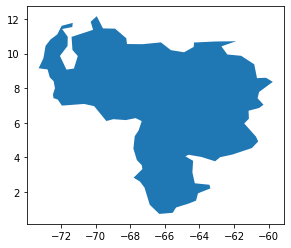

In [8]:
# visualize our study area (country)
study_area = world[world['name'] == w.value]
study_area.plot();

In [9]:
dir_name_24h = folder_names[0]
filename_24h = 'J1_VIIRS_C2_South_America_24h.shp'
path_24h = os.path.join(dir_name_24h, filename_24h)

In [10]:
dir_name_48h = folder_names[1]
filename_48h = 'J1_VIIRS_C2_South_America_48h.shp'
path_48h = os.path.join(dir_name_48h, filename_48h)

In [11]:
dir_name_7d = folder_names[2]
filename_7d = 'J1_VIIRS_C2_South_America_7d.shp'
path_7d = os.path.join(dir_name_7d, filename_7d)

In [12]:
def clip_data(path):
    ptall = gpd.read_file(path)
    
    ptclip = gpd.clip(ptall, study_area)
    
    return ptclip

In [13]:
pt24hclip = clip_data(path_24h)

pt48hclip = clip_data(path_48h)

pt7dclip = clip_data(path_7d)

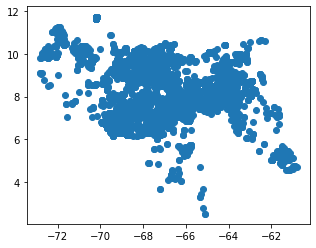

In [14]:
pt7dclip.plot();

In [15]:
def get_locations(pts):
    lats = pts['LATITUDE'].tolist()
    
    lons = pts['LONGITUDE'].tolist()
    
    locs = list(zip(lats, lons))
    
    return locs

In [16]:
pt7dclip.columns

Index(['LATITUDE', 'LONGITUDE', 'BRIGHT_TI4', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'CONFIDENCE', 'VERSION', 'BRIGHT_TI5', 'FRP',
       'DAYNIGHT', 'geometry'],
      dtype='object')

In [17]:
locations24h = get_locations(pt24hclip)

locations48h = get_locations(pt48hclip)

locations7d = get_locations(pt7dclip)

In [18]:
def get_popup(df):
    '''
    Function to get map popup data
    '''
    
    bt4 = df['BRIGHT_TI4'].tolist()
    acd = df['ACQ_DATE'].tolist()
    act = df['ACQ_TIME'].tolist()
    con = df['CONFIDENCE'].tolist()
    bt5 = df['BRIGHT_TI5'].tolist()
    frp = df['FRP'].tolist()
    dynt = df['DAYNIGHT']
    
    poplist = list(zip(bt4, acd, act, con, bt5, frp, dynt))
    popup = ['Brightness temperature I-4 (Kelvin): {}<br>Acquisition Date: {}<br>Acquisition Time: {}\
    <br> Confidence: {}<br>Brightness temperature I-5 (Kelvin): {}<br>Fire Radiative Power (megawatts): {}\
    <br>Day(D) or Night(N): {}'
             .format(b4, ad, at, co, b5, fr, dn) for (b4, ad, at, co, b5, fr, dn) in poplist]
    return popup

In [19]:
centx= study_area['geometry'].centroid.x.tolist()
centy= study_area['geometry'].centroid.y.tolist()
location = [*centy, *centx]

In [20]:
location

[7.162132267639002, -66.16382727830238]

In [21]:
bboxsa = study_area.geometry.bounds.values.tolist()
bbox = [item for sublist in bboxsa for item in sublist]
bbox

[-73.30495154488005,
 0.7244522159820121,
 -59.758284878159195,
 12.162307033736099]

In [22]:
# map = folium.Map(location, zoom_start=6, tiles=False,control_scale=True)
map = folium.Map(location, zoom_start=get_zoom_start(bbox), tiles=False,control_scale=True, prefer_canvas=True)


#[6.569,-65.844]
folium.TileLayer('CartoDB dark_matter', overlay=True).add_to(map)

cluster24h = MarkerCluster(name='24hr VIIRS 375m', overlay=False).add_to(map)
cluster48h = MarkerCluster(name='48hr VIIRS 375m', overlay=False).add_to(map)
cluster7d = MarkerCluster(name='7d VIIRS 375m', overlay=False).add_to(map)

pointIcon24h = "icons/fire24.png"
pointIcon48h = "icons/fire48.png"
pointIcon7d = "icons/fire7d.png"


for loc24h, pop24h in zip(locations24h, get_popup(pt24hclip)):
    folium.Marker(loc24h,
                  icon=folium.features.CustomIcon(pointIcon24h, icon_size=(40, 40)),
                  popup=pop24h
                 ).add_to(cluster24h)
    
for loc48h, pop48h in zip(locations48h, get_popup(pt48hclip)):
    folium.Marker(loc48h,
                  icon=folium.features.CustomIcon(pointIcon48h, icon_size=(40, 40)),
                  popup=pop48h               
              ).add_to(cluster48h)
    
for loc7d, pop7d in zip(locations7d, get_popup(pt7dclip)):
    folium.Marker(loc7d,
                  icon=folium.features.CustomIcon(pointIcon7d, icon_size=(40, 40)),
                  popup=pop7d
              ).add_to(cluster7d)

folium.LayerControl(collapsed=False).add_to(map)

text = 'VIIRS Active Fires in '
date = str(localtime.tm_year)+'/'+str(localtime.tm_mon)+'/'+str(localtime.tm_mday)
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(text + w.value + ' ' + 'on' + ' ' + date)   
map.get_root().html.add_child(folium.Element(title_html))

In [23]:
map_html.legend(map)

In [24]:
map